In [1]:
!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y
!sudo apt-get install poppler-utils -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [4]:
! pip install langchain unstructured[all-docs] pydantic lxml openai chromadb tiktoken opencv-python

  Using cached langchain-0.1.10-py3-none-any.whl (806 kB)
  Using cached unstructured-0.12.5-py3-none-any.whl (1.8 MB)
  Using cached openai-1.13.3-py3-none-any.whl (227 kB)
  Using cached chromadb-0.4.24-py3-none-any.whl (525 kB)
  Using cached tiktoken-0.6.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.4/252.4 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 

In [2]:

import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [3]:

from google.colab import userdata
openai_api_key = userdata.get('OPENAI_API_KEY')

In [4]:
output_path = "./images"

In [5]:
# Get elements
raw_pdf_elements = partition_pdf(
    filename="/content/AC-Aids-for-Dogs_Canine-Periodontal-Disease.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=output_path,
)

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.

In [10]:
# Get text summaries and table summaries
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
summary_chain = LLMChain(
    llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key = openai_api_key, max_tokens=1024),
    prompt=PromptTemplate.from_template(summary_prompt)
)

for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)

In [11]:
# Get image summaries
image_elements = []
image_summaries = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def summarize_image(encoded_image):
    prompt = [
        SystemMessage(content="You are a bot that is good at analyzing images related to Dog's health."),
        HumanMessage(content=[
            {
                "type": "text",
                "text": "Describe the contents of this image."
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = ChatOpenAI(model="gpt-4-vision-preview", openai_api_key=openai_api_key, max_tokens=1024).invoke(prompt)
    return response.content

for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
        summary = summarize_image(encoded_image)
        image_summaries.append(summary)

In [8]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 32.2 MB/s eta 0:00:00


In [12]:
# Create Documents and Vectorstore
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))

In [13]:

vectorstore.save_local("faiss_index")

In [14]:

prompt_template = """
You are a vet doctor and an expert in analyzing dog's health.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [15]:

qa_chain = LLMChain(llm=ChatOpenAI(model="gpt-4", openai_api_key = openai_api_key, max_tokens=1024),
                        prompt=PromptTemplate.from_template(prompt_template))

In [16]:

def answer(question):
    relevant_docs = vectorstore.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

In [17]:

result, relevant_images = answer("What is Tartar?")
print(result)

Tartar, also known as dental calculus, is a form of hardened dental plaque. It is formed by the continual accumulation of minerals from saliva and gingival crevicular fluid in plaque on the teeth. The highlighted teeth in the image show yellow to orange discoloration, which may indicate this tartar buildup. If not addressed, this accumulation can lead to gingivitis or periodontal disease. Good dental hygiene, including regular brushing and veterinary dental check-ups, is important for maintaining a dog's oral health.


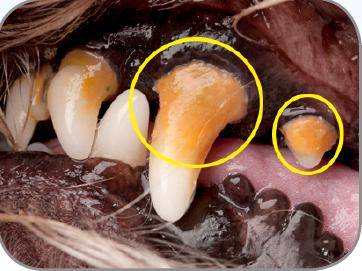

In [19]:

display.display(display.Image(base64.b64decode(relevant_images[0])))